In [20]:
import numpy as np

import matplotlib.pyplot as plt

In [21]:
from key_door import key_door_env, visualisation_env
from sac import utils, binary_maze

from sac.key_door_env_ego import KeyDoorEnvEgocentric

In [22]:
# Meister maze minimized MDP
tree_depth = 6
S, A = np.sum([2**x for x in range(tree_depth)]), 3

# Transition matrix (binary tree)
P = np.zeros((S, A, S))
for r in range(tree_depth - 1):
    for s in range(2**r):
        P[2**r - 1 + s, 0, 2**(r + 1) - 1 + 2 * s] = 1.0
        P[2**r - 1 + s, 1, 2**(r + 1) - 1 + 2 * s + 1] = 1.0
        if r > 0:
            P[2**r - 1 + s, 2, 2**(r - 1) - 1 + s // 2] = 1.0

# leaf nodes transition to previous level
for s in range(2**(tree_depth - 1)):
    P[2**(tree_depth - 1) - 1 + s, 2, 2**(tree_depth - 2) - 1 + s // 2] = 1.0

# Reward function (only at one leaf - action leading to the goal)
R = np.zeros((S, A))
R[2**(tree_depth - 1) - 1, 0] = 1.0

In [23]:
blocks, label = utils.deterministic_bisimulation(P, R)

In [24]:
blocks

[[0],
 [1],
 [2],
 [3],
 [4],
 [5, 6],
 [7],
 [8],
 [9, 10],
 [11, 12, 13, 14],
 [15],
 [16],
 [17, 18],
 [19, 20, 21, 22],
 [23, 24, 25, 26, 27, 28, 29, 30],
 [31],
 [32],
 [33, 34],
 [35, 36, 37, 38],
 [39, 40, 41, 42, 43, 44, 45, 46],
 [47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62]]

In [25]:
S, len(blocks)

(np.int64(63), 21)

In [26]:
maze_str, start_pos, reward_pos = binary_maze.generate_maze_from_mdp(tree_depth, P, R)
print(maze_str)

#############################################
#############################################
#############################################
#############################################
#############################################
#####     #####     #####     #####    R#####
####### ######### ######### ######### #######
#######           #########           #######
####### #### #### ######### #### #### #######
#####     ## ##     #####     ## ##     #####
############ ################### ############
############ ################### ############
############                     ############
############ ######### ######### ############
############ ######### ######### ############
#####     ## ##     ## ##     ## ##     #####
####### #### #### #### #### #### #### #######
#######           #### ####           #######
####### ######### #### #### ######### #######
#####     #####     ## ##     #####     #####
###################### ######################
###################### ###########

In [27]:
start_pos, reward_pos

((22, 2), (5, 39))

In [ ]:
with open("../sac/maps/meister_maze.txt", "w") as f:
    f.write(maze_str)

In [ ]:
map_path = '../sac/maps/meister_maze.txt'
map_yaml_path = '../sac/maps/meister_maze.yaml'

# map_path = '../sac/maps/square_map.txt'
# map_yaml_path = '../sac/maps/square_map.yaml'

In [30]:
episode_timeout = 1000

In [31]:
env = key_door_env.KeyDoorEnv(map_ascii_path=map_path, map_yaml_path=map_yaml_path, representation="agent_position", episode_timeout=episode_timeout)
vis_env = visualisation_env.VisualisationEnv(env)

In [32]:
ego_env = KeyDoorEnvEgocentric(map_ascii_path=map_path, map_yaml_path=map_yaml_path, representation="egocentric", episode_timeout=episode_timeout)
vis_ego_env = visualisation_env.VisualisationEnv(ego_env)

In [33]:
env.reset_environment(train=True)
vis_env.reset_environment(train=True)

ego_env.reset_environment(train=True)
vis_ego_env.reset_environment(train=True)

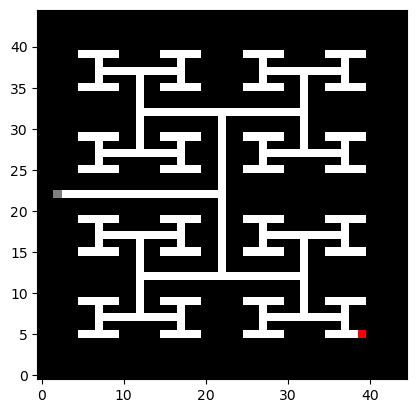

In [34]:
vis_env.render()

In [16]:
state_id_mapping = {state: i for i, state in enumerate(env.positional_state_space)}
id_state_mapping = {i: state for i, state in enumerate(env.positional_state_space)}

In [17]:
S = len(env.positional_state_space)
A = len(env.action_space)

P = np.zeros((S, A, S))
R = np.zeros((S, A))

reward_positions = list(env._rewards.keys())

for state in env.positional_state_space:
    state_index = state_id_mapping[state]
    if state not in reward_positions:
        for action in env.action_space:
            # set env and transition
            env.reset_environment(train=True)
            env.move_agent_to(state)
            reward, new_state = env.step(action)
            if reward > 0:
                print(f"From state {state} taking action {action} to state {new_state} with reward {reward}")
            # import pdb; pdb.set_trace()
            new_state_index = state_id_mapping[new_state[:2]]
            P[state_index][action][new_state_index] = 1
            R[state_index][action] = reward

From state (np.int64(38), np.int64(5)) taking action 2 to state (np.int64(39), np.int64(5), np.int64(1)) with reward 1.0395627215610836


In [17]:
blocks, label = utils.deterministic_bisimulation(P, R)

In [18]:
S, len(blocks)

(393, 393)

In [19]:
state_blocks, sa_blocks, state_label, sa_label, P_tilde, R_tilde, action_index_per_block = utils.joint_state_action_abstraction(P, R)

In [20]:
S, len(state_blocks)

(393, 142)

In [32]:
# create a dictionary mapping state coordinate tuple to state label
state_to_label = {id_state_mapping[i]: state_label[i] for i in range(len(state_label))}

vis_env.plot_heatmap_over_env(state_to_label, save_name='state_aggregation.pdf')
vis_env.plot_heatmap_over_env(state_to_label, save_name='state_aggregation.png')

In [21]:
len(sa_blocks)

143

## Egocentric action space

In [35]:
state_id_mapping = {state: i for i, state in enumerate(ego_env.state_space)}
id_state_mapping = {i: state for i, state in enumerate(ego_env.state_space)}

In [36]:
S = len(ego_env.state_space)
A = len(ego_env.action_space)

P = np.zeros((S, A, S))
R = np.zeros((S, A))

reward_positions = list(ego_env._rewards.keys())

for state in ego_env.state_space:
    state_index = state_id_mapping[state]
    if state not in reward_positions:
        for action in ego_env.action_space:
            # set env and transition
            ego_env.reset_environment(train=True)
            ego_env.move_agent_to(state)
            reward, new_state = ego_env.step(action)
            if reward > 0:
                print(f"From state {state} taking action {action} to state {new_state} with reward {reward}")
            # import pdb; pdb.set_trace()
            new_state_index = state_id_mapping[new_state[:2]]
            P[state_index][action][new_state_index] = 1
            R[state_index][action] = reward

AssertionError: Position must be a tuple of (x,y) coordinates.

In [37]:
ego_env.action_space

{0, 1, 2}

In [38]:
new_state

(np.int64(39), np.int64(39), np.int64(0))

In [39]:
state[0]

(np.int64(5), np.int64(5))

In [55]:
state

((np.int64(5), np.int64(5)), (0,), (), (0,))